In [1]:
import os
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Leitura dos dados e divisão treino/teste

Antes de começarmos, vale ressaltar que o link fornecido no arquivo PDF prova não contém os rótulos da base. Eles podem ser encontrados [aqui](https://github.com/BotechEngineering/StanfordCarsDatasetCSV/tree/main).

A base Standof Cars já possui seus dados divididos  em conjuntos de treinamento e teste. A divisão é, praticamente de 50%-50%. Os dados de teste não estão rotulados por classe. Então, usaremos apenas os dados de treinamento em nossos experimentos.

In [2]:
train_labels = pd.read_csv("data/cardatasettrain.csv")
train_labels.drop(columns=[train_labels.columns[0]], inplace=True)
train_labels

,x1,y1,x2,y2,Class,image
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


Definindo as classes importantes

In [3]:
important_classes = [3,4,5]

Definindo o diretório raiz

In [4]:
train_image_root = 'data/cars_train/cars_train/'

Aqui, vamos adicionar as imagens ao conjunto de treinamento.

In [5]:
train_data = [] #lista de imagens
classes1 = [] #lista de classes das imagens de train_data


In [6]:
for index, row in train_labels.iterrows():
    img = cv2.imread(f"{train_image_root}{row['image']}", cv2.COLOR_BGR2RGB)
    train_data.append(img)
    classes1.append(row['Class'])

Divisão treino e teste, conforme especificado na atividade.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train_data, classes1, test_size=0.3, stratify=classes1, random_state=1)

In [8]:
print("Tamanho do conjunto de treinamento", len(x_train))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de treinamento 5700
Tamanho do conjunto de teste 2444


As classes que não fazem parte da lista `important_classes` receberão o rótulo de 'indefinida'.

In [9]:
x_undefined = []
y_undefined = []
x_defined = []
y_defined = []

for i in range(len(x_train)):
    if y_train[i] not in important_classes:
        y_undefined.append(y_train[i])
        x_undefined.append(x_train[i])
        y_train[i] = 'indefinida'
    else:
        y_defined.append(y_train[i])
        x_defined.append(x_train[i])

for i in range(len(x_test)):
    if y_test[i] not in important_classes:
        y_test[i] = 'indefinida'


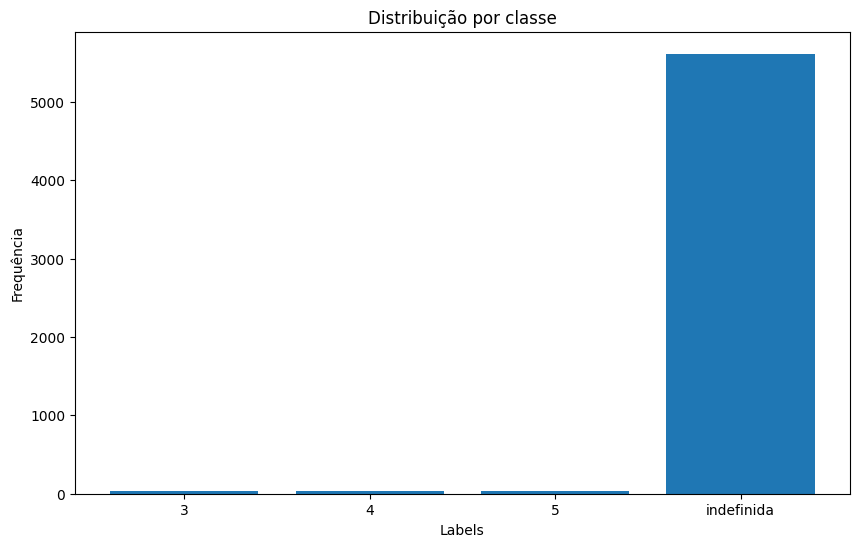

In [10]:
labels, counts = np.unique(np.array(y_train), return_counts=True)
labels = [str(i) for i in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequência')
plt.title('Distribuição por classe')
plt.show()

Observe na imagem acima, que há um enorme desbalanceamento entre as classes. Isso é natural, já que rotulamos 193 classes como 'indefinida'. Precisaremos de um processo robusto para lidarmos com esse conjunto de dados.

In [11]:
# Removemdo variáveis desnecessárias
del train_data, classes1
gc.collect()

3036

# Preprocessamento

Aqui vamos definir um processo de data augmentation. Esse processo vai nos ajudar a aumentar a quantidade de amostras das classes não majoritárias, reduzindo o desbalanceamento.

As imagens que vão sofrer aumento vão passar por um processo seguindo o pipeline:
* Rotação horizontal;
* Ajuste do brilho e contraste;
* Redimensionamento aleatório de escala entre 0% e 5%;
* Recorte aleatório de uma região da imagem;
* Redimensionamento para (224, 224), padrão dos modelos do ImageNet;
* Normalização.

Optamos por manter as imagens originais no conjunto de treinamento (não apenas as versões aumentadas). Essas imagens passarão apenas por um processo de redimensionamento e normalização (`basic_rpocess`).

In [12]:
def basic_process(img):
    # Média e desvio padrão do ImageNet (usaremos para normalização)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Vamos garantir que todas as imagens tenham 3 canis
    if len(img.shape) == 2:  # grayscale para RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:  # único canal para RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img  # Caso a imagem já seja RGB

    # Redimensionar a imgem original para 224x224 (padrão do ImageNet)
    img_rgb = cv2.resize(img_rgb, (224, 224))

    # Normalizar as imagens originais para o formato ImageNet
    img_rgb = img_rgb / 255.0  # Scale to [0, 1] range
    img_rgb = (img_rgb - imagenet_mean) / imagenet_std

    return img_rgb

In [13]:
def data_augmentation(train, classes, num_augmented=2):
    # Média e desvio padrão do ImageNet (usaremos para normalização)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Definimos a pipeline de preprocessamento e aumento de dados
    transform = A.Compose([
        # Aplica uma rotação horizontal aleatória com 50% de chance
        A.HorizontalFlip(p=0.5),  
        # Ajusta o brilho e o contraste aleatoriamente, com limites de 10% e uma chance de 50%
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  
        # Aplica um redimensionamento aleatório de escala entre 0% e 5%, com chance de 50%
        A.RandomScale(scale_limit=(0, 0.05), p=0.5),
        # Recorta aleatoriamente uma região da imagem e redimensiona para 224x224, mantendo a escala entre 80% e 100%, com 50% de chance
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.5),
        # Aplica distorção óptica na imagem com limites de distorção e deslocamento de até 20%, com 50% de chance
        A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.5),
        # Garante que todas as imagens serão redimensionadas para 224x224
        A.Resize(224, 224),  
        # Normaliza as imagens usando a média e o desvio padrão do conjunto de dados ImageNet
        A.Normalize(mean=imagenet_mean, std=imagenet_std, always_apply=True)  
    ])


    # Nestas variáveis armazenaremos as imagens e as classes, após o aumento de dados
    augmented_images = []
    augmented_classes = []

    for img, cls in zip(train, classes):
        # Vamos garantir que todas as imagens tenham 3 canis
        if len(img.shape) == 2:  # grayscale para RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:  # único canal para RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img  # Caso a imagem já seja RGB

        
        # Redimensionar a imgem original para 224x224 (padrão do ImageNet)
        original_img = cv2.resize(img_rgb, (224, 224))

        # Normalizar as imagens originais para o formato ImageNet
        original_img = original_img / 255.0  # Scale to [0, 1] range
        original_img = (original_img - imagenet_mean) / imagenet_std

        # Adicionamos a imagem e as classes
        augmented_images.append(original_img)
        augmented_classes.append(cls)
        
        # Gerar as versões das imagens com base na pipeline
        for _ in range(num_augmented):
            augmented = transform(image=img_rgb)
            augmented_images.append(augmented['image'])
            augmented_classes.append(cls)  # Mantemos a classe correspondente

    # Convertemos as listas para numpy arrays para consistência
    augmented_images = np.array(augmented_images)
    augmented_classes = np.array(augmented_classes)

    return augmented_images, augmented_classes

Aplicamos o processo de aumento das imgens. Usamos um fator 3, o que significa que cada imagem original terá, além de si própria, mais 3 versões aumentadas adicionadas ao conjunto de treinamento.

O processo de aumento de dados não será aplicado à classe majoritária ('indefinida'). Essas imagens passarão apenas por um processo de redimensionamento e normalização (`basic_rpocess`).

In [14]:
# Filtra as imagens e rótulos que não pertencem à classe "indefinida"
x_train_definida = [x for x, y in zip(x_train, y_train) if y != 'indefinida']
y_train_definida = [y for y in y_train if y != 'indefinida']

# Filtra as imagens e rótulos da classe "indefinida"
x_train_indefinida = [x for x, y in zip(x_train, y_train) if y == 'indefinida']
y_train_indefinida = [y for y in y_train if y == 'indefinida']
x_train_indefinida = [basic_process(val) for val in x_train_indefinida] # Aplica redimensionamento e normalização

# Aplica o processo de aumento de dados apenas nas imagens que não são da classe "indefinida"
x_train_augmented, y_train_augmented = data_augmentation(x_train_definida, y_train_definida, num_augmented=1)

# Recombina as imagens e rótulos originais da classe "indefinida" com os dados aumentados
x_train_final = list(x_train_augmented) + x_train_indefinida
y_train_final = list(y_train_augmented) + y_train_indefinida

x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)

In [15]:
# Removendo variáveis desnecessárias
del x_train_definida, y_train_definida, x_train_indefinida, y_train_indefinida
gc.collect()

109

In [16]:
print("Tamanho do conjunto de treinamento", len(x_train_final))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de treinamento 5788
Tamanho do conjunto de teste 2444


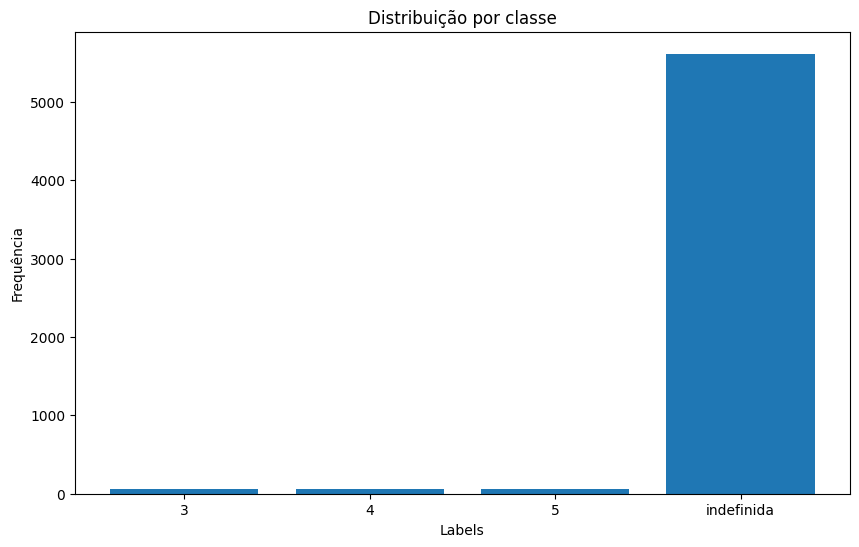

In [17]:
labels, counts = np.unique(np.array(y_train_final), return_counts=True)
labels = [str(i) for i in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequência')
plt.title('Distribuição por classe')
plt.show()

In [18]:
print(counts)

[  60   58   58 5612]


Perceba que, mesmo após o aumento, o desbalanceamento de dados ainda é muito grande

# Treinamento do modelo

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

2024-11-04 21:13:48.928536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 21:13:49.044787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 21:13:49.074355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 21:13:49.290687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 21:13:50.412832: W tensorflow/compiler/tf2

In [20]:
@register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=1.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)

    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    fl = -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
    return K.mean(fl)

@register_keras_serializable()
def focal_loss(gamma=2.0, alpha=1.0):
    def loss(y_true, y_pred):
        return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
    return loss

In [21]:
def select_balanced_subset(x_train, y_train):
    # Conta a quantidade de amostras de cada classe
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    
    # Ordena as contagens de amostras por classe em ordem decrescente
    sorted_counts = np.sort(class_counts)[::-1]
    
    # Define n_minor como o número de amostras da classe minoritária mais frequente
    # (a segunda maior contagem de amostras)
    n_minor = sorted_counts[1] if len(sorted_counts) > 1 else sorted_counts[0]
    
    # Identifica a classe majoritária
    major_class = unique_classes[np.argmax(class_counts)]
    
    # Encontra os índices para a classe majoritária e as classes minoritárias
    major_indexes = [i for i, label in enumerate(y_train) if label == major_class]
    minor_indexes = [i for i, label in enumerate(y_train) if label != major_class]
    
    # Seleciona aleatoriamente n_minor amostras da classe majoritária
    selected_major_indexes = np.random.choice(major_indexes, n_minor, replace=False)
    
    # Combina as amostras selecionadas da classe majoritária com todas as amostras das classes minoritárias
    selected_indexes = np.concatenate([selected_major_indexes, minor_indexes])
    
    # Filtra x_train e y_train usando os índices selecionados
    x_train_final = x_train[selected_indexes]
    y_train_final = y_train[selected_indexes]
    
    return x_train_final, y_train_final

In [22]:
def ODU_with_variety(model, x_tr, y_tr, y_undefined, batch_size=32, n_per_class=2):
    # Divide x_tr em batches para evitar estouro de memória
    y_pred = []
    for i in range(0, len(x_tr), batch_size):
        batch_x = x_tr[i:i + batch_size]
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred.extend(batch_pred)  # Adiciona as previsões ao array principal
    
    y_pred = np.array(y_pred)  # Converte a lista de previsões para um array numpy

    # Conta a quantidade de amostras de cada classe
    unique_classes, class_counts = np.unique(y_tr, return_counts=True)
    major_class = unique_classes[np.argmax(class_counts)]  # Classe majoritária
    major_class_idx = np.argmax(class_counts)  # Índice da classe majoritária
    # Tamanho da classe minoritária mais frequente (maior valor entre as classes minoritárias)
    n_minor = np.max(class_counts[class_counts != class_counts[major_class_idx]])
    
    # Inicializa listas para índices da classe majoritária e minoritárias
    major_indexes = []
    minor_indexes = []
    major_class_pred = []
    
    # Agrupa índices das classes majoritária e minoritárias
    for idx, prediction in enumerate(y_pred):
        if y_tr[idx] == major_class:
            major_class_pred.append(prediction[major_class_idx])
            major_indexes.append(idx)
        else:
            minor_indexes.append(idx)

    # Ordena os índices da classe majoritária de acordo com as probabilidades preditas
    major_indexes = [x for _, x in sorted(zip(major_class_pred, major_indexes))]
    
    # Seleciona o mesmo número de amostras da classe majoritária que a classe minoritária mais frequente
    selected_major_indexes = major_indexes[:n_minor]

    # Inicializa listas para seleção das amostras indefinidas com maior dificuldade (menor confiança)
    indef_pred = []
    indef_indexes = []
    variation_indexes = []
    
    # Coleta as previsões e índices para as amostras indefinidas (major_class)
    for j, cls in enumerate(y_tr):
        if cls == major_class:
           indef_pred.append(y_pred[j])
           indef_indexes.append(j)

    # Converte indef_pred para array numpy para permitir indexação
    indef_pred = np.array(indef_pred)       
 
    # Ordena indef_indexes e y_undefined com base na dificuldade (confiança baixa)
    indef_indexes = [val for _, val in sorted(zip(indef_pred[:, major_class_idx], indef_indexes))]
    y_undefined = [val for _, val in sorted(zip(indef_pred[:, major_class_idx], y_undefined))]

    # Seleciona n_per_class amostras mais difíceis para cada classe indefinida em y_undefined
    for cls in np.unique(y_undefined):
        count = 0
        for i, val in enumerate(indef_indexes):
            if val not in selected_major_indexes:
                count += 1
                
            if y_undefined[i] == cls and count < n_per_class:
                variation_indexes.append(val)
                count += 1
            if count == n_per_class:
                break

    # Junta os índices das classes minoritárias, majoritária e as amostras variadas indefinidas
    selected_indexes = selected_major_indexes + minor_indexes + variation_indexes
    print(len(selected_indexes))
    
    # Seleciona as amostras e rótulos correspondentes
    new_x_tr = [x_tr[i] for i in selected_indexes]
    new_y_tr = [y_tr[i] for i in selected_indexes]
    
    return np.array(new_x_tr), np.array(new_y_tr)

In [23]:
@tf.keras.utils.register_keras_serializable()
def f1_score_macro(y_true, y_pred):
    # Converte as previsões para valores binários (0 ou 1) e garante que são do tipo float
    y_pred = K.cast(K.round(y_pred), 'float32')
    y_true = K.cast(y_true, 'float32')
    
    # Calcula o número de Verdadeiros Positivos, Falsos Positivos e Falsos Negativos
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    # Calcula Precision e Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calcula o F1-score para cada classe e tira a média (macro)
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = K.mean(f1)  # Média dos F1-scores de todas as classes
    
    return f1

In [24]:
n_classes = len(np.unique(y_train_final))

base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.compile(optimizer='Adam', loss=focal_loss(), metrics=[f1_score_macro])

I0000 00:00:1730765631.510977   33019 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730765631.947963   33019 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730765631.948209   33019 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730765631.950109   33019 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

: 

In [25]:
for i in range(2):
    if i == 0:
        # No primeiro passo, amostras selecionadas aleatoriamente
        x_train_balanced, y_train_balanced = select_balanced_subset(x_train_final, y_train_final)
        print(len(y_train_balanced))
    else:
        # Nos passos subsequentes, amostras selecionadas pelo método ODU_multiclass
        x_train_balanced, y_train_balanced = ODU_with_variety(model, x_train_final, x_train_final, y_undefined, batch_size=32, n_per_class=1)
        print(len(y_train_balanced))

    # Cria o dataset com balanceamento e aumento de desempenho
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_balanced, pd.get_dummies(y_train_balanced)))
    train_dataset = train_dataset.shuffle(buffer_size=1000)  # Embaralha o dataset
    train_dataset = train_dataset.batch(8)                  # Aplica um batch
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Otimiza a performance

    # Treina o modelo por 1 época usando o dataset balanceado
    model.fit(train_dataset, epochs=1)
    
model.save("trained_model.keras")   

236


I0000 00:00:1730765662.843327   33097 service.cc:146] XLA service 0x782498003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730765662.843349   33097 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-11-04 21:14:24.142722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-04 21:14:28.279068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1730765678.609647   33097 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730765678.726185   33097 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sys

 2/30 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - f1_score_macro: 0.0000e+00 - loss: 0.2170  

I0000 00:00:1730765712.476245   33097 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - f1_score_macro: 0.2413 - loss: 0.2075

E0000 00:00:1730765727.199716   33097 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730765727.315881   33097 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - f1_score_macro: 0.2483 - loss: 0.2064


In [26]:
del x_train, x_train_augmented,	x_train_final, y_train,	y_train_augmented, y_train_final	
gc.collect()

18708

In [26]:
labels, counts = np.unique(np.array(y_train_balanced), return_counts=True)
labels

array(['3', '4', '5', 'indefinida'], dtype='<U10')

In [27]:
counts

array([227, 116, 116, 120])

In [27]:
model = tf.keras.models.load_model("trained_model.keras", custom_objects={'focal_loss_fixed': focal_loss_fixed, 'focal_loss': focal_loss})

TypeError: Could not locate function 'f1_score_macro'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'f1_score_macro', 'registered_name': 'function'}

In [28]:
x_test = [basic_process(x) for x in x_test]
x_test = np.array(x_test)

In [29]:
y_pred = []
for i in range(0, len(x_test), 10):
    batch_x = x_test[i:i + 10]
    batch_pred = model.predict(batch_x, verbose=0)
    y_pred.extend(batch_pred)  # Adiciona as previsões ao array principal
y_pred = np.array(y_pred)    

y_pred = pd.DataFrame(y_pred)
y_pred.columns = important_classes + ['indefinida']
y_pred = y_pred.idxmax(axis=1)

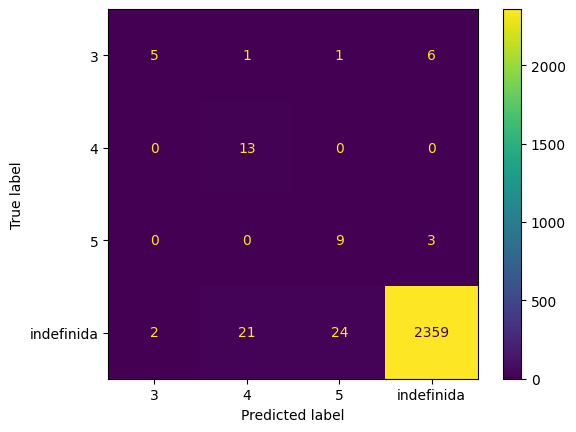

              precision    recall  f1-score   support

           3       0.71      0.38      0.50        13
           4       0.37      1.00      0.54        13
           5       0.26      0.75      0.39        12
  indefinida       1.00      0.98      0.99      2406

    accuracy                           0.98      2444
   macro avg       0.59      0.78      0.61      2444
weighted avg       0.99      0.98      0.98      2444



In [30]:
y_test = np.array(y_test).astype(str)
y_pred = y_pred.astype(str)
labels = np.array(important_classes + ['indefinida']).astype(str)

# Matriz de confusão
cf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
cm_display.plot()
plt.show()

# Relatório de classificação
relatorio = classification_report(y_test, y_pred, target_names=['3', '4', '5', 'indefinida'])
print(relatorio)